In [11]:
import pandas as pd
import numpy as np
from indicnlp.tokenize import indic_tokenize  
from gensim.models import Word2Vec
import re
import html
import tqdm 
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')
from spacy.lang.hi import STOP_WORDS as STOP_WORDS_HI
import hindi_stemmer  ## https://research.variancia.com/hindi_stemmer/
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
dataset = pd.read_csv("../dataset/hindi_dataset/hindi_dataset/hindi_dataset.tsv", delimiter="\t")
word2vec_model = Word2Vec.load("../embeddings/hindi-word2vec/hi.bin")
re1 = re.compile(r' +')
test_set = pd.read_csv("../dataset/hindi_dataset/hindi_dataset/hasoc2019_hi_test_gold_2919.tsv", delimiter="\t")

In [3]:
def pre_process(dataset):
    sentences = dataset["text"].tolist()
    data_labels = dataset["task_1"].tolist()

    vectors = []
    labels = []
    for i, sentence in tqdm.tqdm(enumerate(sentences)):
        flag, vector = get_sentence_vector(sentence)
        if(flag==False):
            continue
        label = get_binary_labels(data_labels[i])
        vectors.append(vector)
        labels.append(label)
    
    return np.array(vectors), labels

def get_sentence_vector(sentence):
    tokens = indic_tokenize.trivial_tokenize(sentence)
    tokens = [token for token in tokens if token not in STOP_WORDS_HI]
    tokens = [hindi_stemmer.hi_stem(token) for token in tokens]
    
    vector = []
    for token in tokens:
        if(token not in word2vec_model):
            continue
        embedding = word2vec_model[token]
        vector.append(embedding)
        
    vector = np.array(vector)
    if(len(vector)==0):
        return False, vector
    vector = np.mean(vector, axis = 0)
    return True, vector

def get_binary_labels(label):
    if(label=="HOF"):
        return 1
    else:
        return 0

In [19]:
vectors, labels = pre_process(dataset)
test_vectors, test_labels = pre_process(test_set)

4665it [00:01, 3838.80it/s]
1318it [00:00, 3297.05it/s]


In [26]:
# ref : sklearn
from sklearn.linear_model import LogisticRegression
from sklearn import svm, tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import roc_curve, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.svm import LinearSVC

model_names = ['QDA', 'LDA', 'MLP', 'LR', 'DT', 'RF', 'NB', 'KNN', 'AdaBoost', 'SVM']

models = [
    LinearDiscriminantAnalysis(),
    MLPClassifier(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(5, 2), random_state=1), 
    LogisticRegression(random_state=0, penalty='none'),
    tree.DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(n_estimators=100),
    GaussianNB(),
    KNeighborsClassifier(n_neighbors=5),
    AdaBoostClassifier(n_estimators=100, random_state=0),
    svm.SVC(kernel='linear',probability=True)
]

result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc', 'p', 'r', 'acc', 'f1'])

for i, model in enumerate(models):
    print(model.__class__.__name__)
    model.fit(vectors, labels)
    y_predicted = model.predict(vectors)
    print(accuracy_score(y_predicted, labels))
    y_predicted = model.predict(test_vectors)
    acc = accuracy_score(y_predicted, test_labels)
    print("test acc :", acc)
    y_prob = model.predict_proba(test_vectors)[::,1]
    fpr, tpr, _ = roc_curve(test_labels, y_prob)
    auc = roc_auc_score(test_labels, y_prob)
    precision = precision_score(y_predicted, test_labels)
    recall = recall_score(y_predicted, test_labels)
    fscore = f1_score(y_predicted, test_labels)
    print("auc :" ,auc )
    print("precision :", precision)
    print("recall :", recall)
    print("f_score :", fscore )
    result_table = result_table.append({'classifiers':model.__class__.__name__,
                                    'fpr':fpr, 
                                    'tpr':tpr, 
                                    'auc':auc,
                                    'p': precision,
                                    'r': recall,
                                    'acc' :acc,
                                    'f1': fscore}, ignore_index=True)
    print("\n\n")
    
result_table.set_index('classifiers', inplace=True)

LinearDiscriminantAnalysis
0.7570196772053946
test acc : 0.7092307692307692
auc : 0.7795028986472979
precision : 0.7724252491694352
recall : 0.6586402266288952
f_score : 0.7110091743119268



MLPClassifier
0.856068980764979
test acc : 0.7
auc : 0.7465754076668984
precision : 0.7591362126245847
recall : 0.6509971509971509
f_score : 0.700920245398773



LogisticRegression
0.7581251381826222
test acc : 0.7115384615384616
auc : 0.7773574712753097
precision : 0.7641196013289037
recall : 0.6637806637806638
f_score : 0.7104247104247106



DecisionTreeClassifier
0.7158965288525315
test acc : 0.6261538461538462
auc : 0.6680180201620196
precision : 0.7475083056478405
recall : 0.5739795918367347
f_score : 0.6493506493506493



RandomForestClassifier
0.9838602697324784
test acc : 0.6846153846153846
auc : 0.7595800531180688
precision : 0.782392026578073
recall : 0.628
f_score : 0.6967455621301776



GaussianNB
0.6274596506743312
test acc : 0.6130769230769231
auc : 0.6685630039314987
precision : 0.5

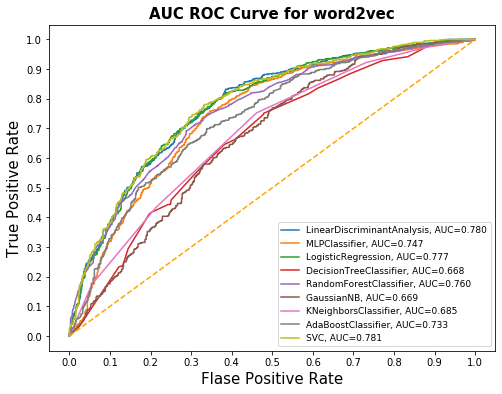

In [29]:
fig = plt.figure(figsize=(8,6))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("Flase Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('AUC ROC Curve for word2vec', fontweight='bold', fontsize=15)
plt.legend(prop={'size':9}, loc='lower right')

plt.show()

In [86]:
def accuracy(predicted_labels, true_labels):
    acc = 0
    for i in range(len(true_labels)):
        if(predicted_labels[i]==true_labels[i]):
            acc+=1
    
    return 100*acc/len(true_labels)

In [87]:
accuracy_score(y_predicted, labels)

0.7714348688560723

In [88]:
## testing phase --
test_set = pd.read_csv("../dataset/hindi_dataset/hindi_dataset/hasoc2019_hi_test_gold_2919.tsv", delimiter="\t")
test_vectors, test_labels = pre_process(test_set)


0it [00:00, ?it/s]C:\Users\Zaki\anaconda3\lib\site-packages\ipykernel_launcher.py:30: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
C:\Users\Zaki\anaconda3\lib\site-packages\ipykernel_launcher.py:33: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

296it [00:00, 2845.85it/s]
641it [00:00, 2972.19it/s]
1318it [00:00, 3230.12it/s][A


In [83]:

y_predicted = logistic_regression.predict(test_vectors)
accuracy_score(y_predicted, test_labels)


0it [00:00, ?it/s]C:\Users\Zaki\anaconda3\lib\site-packages\ipykernel_launcher.py:30: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
C:\Users\Zaki\anaconda3\lib\site-packages\ipykernel_launcher.py:33: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

121it [00:00, 1153.90it/s]
265it [00:00, 1222.97it/s]
367it [00:00, 1145.72it/s]
464it [00:00, 1061.59it/s]
579it [00:00, 1063.07it/s]
697it [00:00, 1077.27it/s]
807it [00:00, 1083.42it/s]
911it [00:00, 1068.99it/s]
1012it [00:00, 1006.42it/s]
1121it [00:01, 1028.09it/s]
1318it [00:01, 1094.76it/s]


0.7323076923076923

In [75]:
len(test_labels)

1300